<a href="https://colab.research.google.com/github/mulqueenr/DSWG_MethylationWorkshop/blob/main/DSWG_Methylation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the DSWG Methylation workshop!

I'll be running you through an vignette of amethyst processing, based heavily off the vignette for PBMC processing available on the amethyst github repo.

We will be processing from breast cancer cell line cells.

Our goals in this workshop are to:

- Get familiar with quality metrics of DNA methylation
- Cluster single cell methylomes to separate out the cell lines.
- Perform copy number calling to confirm our clusters.

## Library Installation

I prebuilt some R libraries that we can use to skip the install process. If you want to run the install yourself, the code is commented out below. You can fully ignore the commented out code below. All it is showing is that we need to install quite a few dependencies to get to the installation of two packages that will be the focus on this workshop:

- **amethyst**: single cell methylation processing
- **copykit**: single cell whole genome copy number calling

In [4]:
#first lets install packages for the tutorial
# this is prerun and stored on google drive to save time

#install.packages("BiocManager")

#library("BiocManager")
#BiocManager::install(c("caret", "devtools", "data.table", "dplyr", "furrr", "future", "future.apply",
#  "ggplot2", "grDevices", "gridExtra", "igraph", "irlba", "janitor", "Matrix", "methods", "pheatmap",
#  "plotly", "plyr", "purrr", "randomForest", "rhdf5", "rtracklayer", "Rtsne", "scales", "stats", "stringr",
#  "tibble", "tidyr", "umap", "utils"))

#library("devtools")

#devtools::install_github("JinmiaoChenLab/Rphenograph")
#devtools::install_github("KrishnaswamyLab/MAGIC/Rmagic")
#devtools::install_github("TomKellyGenetics/leiden")
#installing older version of amethyst for compatibility with cell line data files.
#system('wget https://github.com/lrylaarsdam/amethyst/releases/download/v0.0.0.9000/amethyst_0.0.0.9000.tar.gz')
#system('tar -xf amethyst_0.0.0.9000.tar.gz')
#devtools::install("/content/amethyst")
#devtools::install_github("navinlabcode/copykit")
#system('cd /usr/local/lib/R/site-library/; tar -czf /content/R_library.tar.gz *; cd /content')



To save ~30min of installation time, I prebuild the library and uploaded to a google drive folder. The following code downloads the libraries, and uncompresses them, so we can use them in our R session.

We'll also download the cell line methylation data while here.

In [5]:
#download prebuilt R libraries
system("gdown '1r2P-GZa2QukEl-i619yK7dqeoEhGjBNN'")
system("mkdir R_library")
system("tar -xvf R_library.tar.gz -C R_library") #unpack the library

In [6]:
#download data
system("gdown '195TI6-r2ruEGaKK4rIfWa24aT2xyEjL5'")
system("tar -xf workshop_data.tar.gz") #unpack the library

If you check your files for this colab session, you should see them populate with two folders:

- **R_library.tar.gz** : this is our downloaded compressed libraries
- **/R_library/** : this is our decompressed folder
- **h5_files** : this contains our methylation data in compressed h5 format
- **metadata.tsv** : this is a tab-separated format of our metadata
- **workshop.copykit.obj.rds** : this is a bonus copykit object that we will use for cnv calling

Now all we have to do is tell R where to look for these libraries and we should be good to go!

To do this, we are going to append the folder location to an R environment variable called ".libPaths".

Following this we will load our packages.

In [7]:

.libPaths(c("/content/R_library", .libPaths()))
library(amethyst)
library(copykit)
library(ggplot2)

.libPaths()

Warning message:
“replacing previous import ‘GenomicRanges::reduce’ by ‘purrr::reduce’ when loading ‘amethyst’”
Attaching amethyst version 0.0.0.9000.

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCumm

[1] "/content/R_library"            "/usr/local/lib/R/site-library"
[3] "/usr/lib/R/site-library"       "/usr/lib/R/library"

# Let's Assemble our Amethyst Object

![amethyst_layout.png](https://github.com/lrylaarsdam/amethyst/blob/main/images/objectstructure.png?raw=true)

In [8]:
#read in our metadata first
meta<-read.csv(file="/content/metadata.tsv",header=T,sep="\t")
head(meta)

,cell_id,tgmt_well,i5_well,i7_well,plate,batch,plate_info,unique_reads,total_reads,mito_reads,mcg_pct,cov,ch_cov,tss_enrich,cg_cov,mch_pct,sample
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>
CGAATCTCCT+CTTCGGCGCA+AACTGTAG+prelim1-2_scalebio_plate1-1,CGAATCTCCT+CTTCGGCGCA+AACTGTAG,1A06,E01,A05,plate1-1,prelim1-2,prelim1-2_scalebio_plate1-1,691748,1148393,0.001,68.92,12034132,11566095,0.7604,468037,0.68,MCF10A
GTCTCCAGAG+TCGTAGGCTT+AACTGTAG+prelim1-2_scalebio_plate1-1,GTCTCCAGAG+TCGTAGGCTT+AACTGTAG,1A06,H01,A06,plate1-1,prelim1-2,prelim1-2_scalebio_plate1-1,640821,1037107,0.001,69.59,11440496,11008909,0.7406,431587,0.67,MCF10A
GTCTCCAGAG+ACCGGAATTA+ATAATGTG+prelim1-2_scalebio_plate1-1,GTCTCCAGAG+ACCGGAATTA+ATAATGTG,1B03,D01,A06,plate1-1,prelim1-2,prelim1-2_scalebio_plate1-1,555624,905954,0.001,68.82,9897578,9523222,0.7230,374356,0.71,MCF10A
AATTGAGAGA+TCGTAGGCTT+AACTGTAG+prelim1-2_scalebio_plate1-1,AATTGAGAGA+TCGTAGGCTT+AACTGTAG,1A06,H01,A11,plate1-1,prelim1-2,prelim1-2_scalebio_plate1-1,536382,873647,0.001,69.03,9525741,9162261,0.6952,363480,0.66,MCF10A
TCGAAGCGCG+GGCAATGAGA+ATAATGTG+prelim1-2_scalebio_plate1-1,TCGAAGCGCG+GGCAATGAGA+ATAATGTG,1B03,B01,A07,plate1-1,prelim1-2,prelim1-2_scalebio_plate1-1,497105,776195,0.000,69.49,9038954,8701616,0.7497,337338,0.69,MCF10A
CGAATCTCCT+GGCAATGAGA+AACTGTAG+prelim1-2_scalebio_plate1-1,CGAATCTCCT+GGCAATGAGA+AACTGTAG,1A06,B01,A05,plate1-1,prelim1-2,prelim1-2_scalebio_plate1-1,435953,736252,0.000,70.15,7644320,7353858,0.7426,290462,0.70,MCF10A


In [9]:
#read in our h5 filesobj <- addCellInfo(obj, file = "metadata.tsv")
h5_paths<-read.csv(file="/content/h5_files/h5_paths.tsv",header=T,sep="\t")
h5_paths$barcodes<-row.names(h5_paths)
h5_paths$paths<-h5_paths$path
h5_paths<-h5_paths[,c("barcodes","paths")]
head(h5_paths)

,barcodes,paths
,<chr>,<chr>
CGAATCTCCT+CTTCGGCGCA+AACTGTAG+prelim1-2_scalebio_plate1-1,CGAATCTCCT+CTTCGGCGCA+AACTGTAG+prelim1-2_scalebio_plate1-1,/content/h5_files/MCF10A.1A06_cov.h5
GTCTCCAGAG+TCGTAGGCTT+AACTGTAG+prelim1-2_scalebio_plate1-1,GTCTCCAGAG+TCGTAGGCTT+AACTGTAG+prelim1-2_scalebio_plate1-1,/content/h5_files/MCF10A.1A06_cov.h5
GTCTCCAGAG+ACCGGAATTA+ATAATGTG+prelim1-2_scalebio_plate1-1,GTCTCCAGAG+ACCGGAATTA+ATAATGTG+prelim1-2_scalebio_plate1-1,/content/h5_files/MCF10A.1B03_cov.h5
AATTGAGAGA+TCGTAGGCTT+AACTGTAG+prelim1-2_scalebio_plate1-1,AATTGAGAGA+TCGTAGGCTT+AACTGTAG+prelim1-2_scalebio_plate1-1,/content/h5_files/MCF10A.1A06_cov.h5
TCGAAGCGCG+GGCAATGAGA+ATAATGTG+prelim1-2_scalebio_plate1-1,TCGAAGCGCG+GGCAATGAGA+ATAATGTG+prelim1-2_scalebio_plate1-1,/content/h5_files/MCF10A.1B03_cov.h5
CGAATCTCCT+GGCAATGAGA+AACTGTAG+prelim1-2_scalebio_plate1-1,CGAATCTCCT+GGCAATGAGA+AACTGTAG+prelim1-2_scalebio_plate1-1,/content/h5_files/MCF10A.1A06_cov.h5


You'll notice for both the h5 paths and the metadata, the row names of the files are the same. So through this we will like our cell info to the methylation profiles! Now let's make a new amethyst object.

In [10]:
obj <- createObject()
str(obj)

Formal class 'amethyst' [package "amethyst"] with 6 slots
  ..@ h5paths       : NULL
  ..@ genomeMatrices: NULL
  ..@ reductions    : NULL
  ..@ index         : NULL
  ..@ metadata      : NULL
  ..@ ref           : NULL


The "@" symbol shows a slot in the object. These are predefined in R, so they only accept certain data types and formats.

We will start by adding our h5 paths into the @h5paths slot, and our metadata into the @metadata slot. We'll then just do another quick check to make sure it got added correctly.

In [11]:
obj@metadata<-meta
obj@h5paths<-h5_paths[row.names(meta),]


R structured objects are hierarchical. So we can call a slot, and then call further objected within that slot.

Let's make a quick counts table of our "sample" metadata column.

In [12]:
table(obj@metadata$sample)



    MCF10A       MCF7 MDA-MB-231 
        55         52         48 

Looks like we're working with about 50 cells a piece for 3 different cell lines. Let's take a peek at the coverage per cell as a histogram.

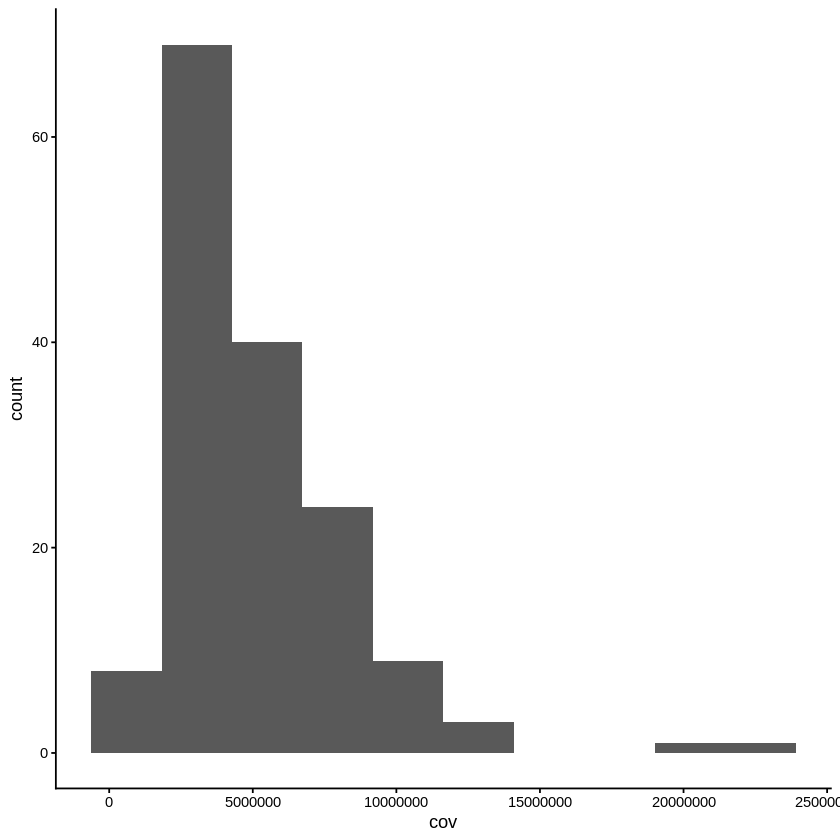

In [13]:
ggplot(obj@metadata, aes(x = cov)) + geom_histogram(bins = 10) + theme_classic()

# Clustering

Now let's cluster our data based on the methylome profiles. First we will index our CG sites in our h5 files. This will allow us to access them for summarizing over windows more efficiently. We can now take a peek at some chr1 data.

In [15]:
obj@index[["chr_cg"]] <- indexChr(obj, type = "CG", threads = 4)
head(obj@index[["chr_cg"]][["chr1"]])

In [ ]:
obj@genomeMatrices[["cg_100k_score"]] <- makeWindows(obj,
                                                    stepsize = 100000,
                                                    type = "CG",
                                                    metric = "score",
                                                    threads = 1,
                                                    index = "chr_cg",
                                                    nmin = 2)